In [129]:
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
import math
# from util import findCentroid, rotateImage, halveTheRegionHorizontally, computeAsymmetry

import numpy as np
from PIL import Image
from skimage.measure import find_contours, label
from skimage.morphology import binary_closing

# ENV
import os

# ISIC API
import requests
import glob

# Main data structure(s)
import pandas as pd
import numpy as np

# For pi value
import math

# For API calls
import time
import json

# Building a data set
import shutil
import zipfile
from io import BytesIO

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Data normalization
from sklearn import preprocessing

# Feature extraction
from skimage import morphology
from skimage.transform import rotate
from scipy.spatial.distance import cdist
from scipy.stats.stats import mode

# Color 'brightness' (value) spread
from skimage.segmentation import slic # Segments image using k-means clustering in Color-(x,y,z) space
from skimage.measure import regionprops
from skimage.color import rgb2hsv # Converts RGB color to HSV (Hue, Saturation, Value)

# Proper split of training and test data
from sklearn.model_selection import train_test_split

# Feature selection
from sklearn.feature_selection import chi2, mutual_info_classif, SelectKBest

# Model building
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For model evaluation
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score

C:\Users\jackh\AppData\Local\Temp\ipykernel_7456\1030840979.py:49: DeprecationWarning: Please use `mode` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import mode


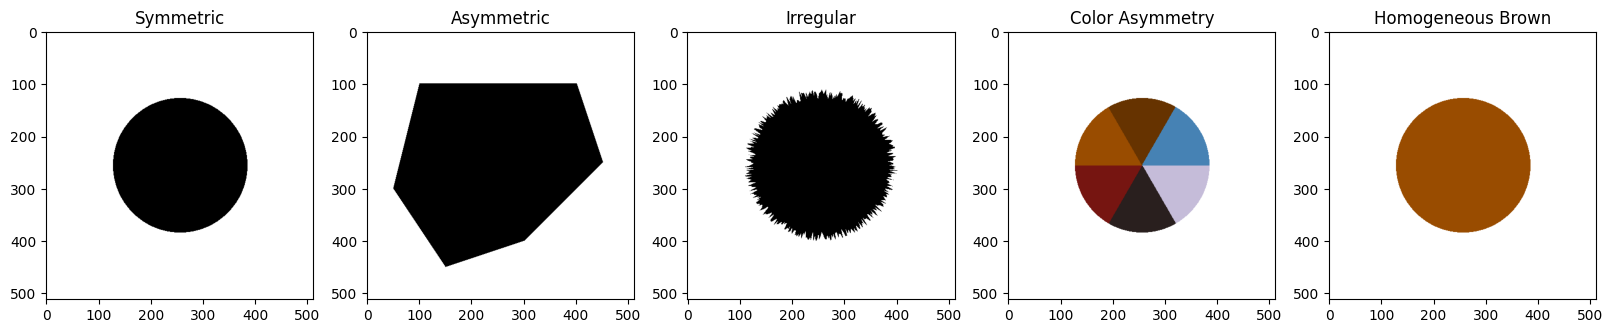

In [135]:
# Create a blank 512x512 image with a white background
width, height = 512, 512
symmetric_img = Image.new('1', (width, height), 'white')

# Draw a circle in the center of the image
draw = ImageDraw.Draw(symmetric_img)
circle_radius = min(width, height) // 4
circle_center = (width // 2, height // 2)
draw.ellipse((circle_center[0] - circle_radius, circle_center[1] - circle_radius,
              circle_center[0] + circle_radius, circle_center[1] + circle_radius),
             fill='black')

# Create a blank 512x512 image with a white background
width, height = 512, 512
asymmetric_img = Image.new('1', (width, height), 'white')

# Draw an asymmetric polygon on the image
draw = ImageDraw.Draw(asymmetric_img)
polygon_points = [
    (100, 100),
    (400, 100),
    (450, 250),
    (300, 400),
    (150, 450),
    (50, 300)
]
draw.polygon(polygon_points, fill='black')

# Create a blank 512x512 image with a white background
width, height = 512, 512
irregular_img = Image.new('1', (width, height), 'white')

# Draw an irregular circular border on the image
draw = ImageDraw.Draw(irregular_img)
circle_center = (width // 2, height // 2)
radius = min(width, height) // 2 - 120
num_segments = 500
angle_step = 2 * math.pi / num_segments

# Generate points for the irregular border
points = []
for i in range(num_segments):
    angle = i * angle_step
    random_radius_offset = random.uniform(-10, 10)
    x = circle_center[0] + (radius + random_radius_offset) * math.cos(angle)
    y = circle_center[1] + (radius + random_radius_offset) * math.sin(angle)
    points.append((x, y))

# Draw the irregular border figure
draw.polygon(points, fill='black')


# Create a blank 512x512 image with a white background
width, height = 512, 512
colorasymmetry_img = Image.new('RGB', (width, height), 'white')
draw = ImageDraw.Draw(colorasymmetry_img)

# Draw a circle with specified colors
circle_radius = min(width, height) // 4
circle_center = (width // 2, height // 2)
colors = [
    (197, 188, 217), # white
    (41, 31, 30),   # black
    (118, 21, 17),  # red
    (153, 76, 0),  # light brown
    (102, 51, 0),  # dark brown
    (70, 130, 180)  # blue-gray
]

num_colors = len(colors)
angle_step = 360 // num_colors

for idx, color in enumerate(colors):
    start_angle = angle_step * idx
    end_angle = angle_step * (idx + 1)
    draw.pieslice((circle_center[0] - circle_radius, circle_center[1] - circle_radius,
                   circle_center[0] + circle_radius, circle_center[1] + circle_radius),
                  start=start_angle, end=end_angle, fill=color)


# Create a blank 512x512 image with a white background
width, height = 512, 512
homogeneous_brown_img = Image.new('RGB', (width, height), 'white')

# Draw a circle in the center of the image with a homogenous brown color
draw = ImageDraw.Draw(homogeneous_brown_img)
circle_radius = min(width, height) // 4
circle_center = (width // 2, height // 2)
brown_color = (153, 76, 0)  # Brown color

draw.pieslice((circle_center[0] - circle_radius, circle_center[1] - circle_radius,
               circle_center[0] + circle_radius, circle_center[1] + circle_radius),
              start=0, end=360, fill=brown_color)


# display all images side by side as Matplotlib figure with title for each image
fig, ax = plt.subplots(1, 5, figsize=(20, 20))
ax[0].imshow(symmetric_img, cmap='gray')
ax[0].set_title('Symmetric')
ax[1].imshow(asymmetric_img, cmap='gray')
ax[1].set_title('Asymmetric')
ax[2].imshow(irregular_img, cmap='gray')
ax[2].set_title('Irregular')
ax[3].imshow(colorasymmetry_img)
ax[3].set_title('Color Asymmetry')
ax[4].imshow(homogeneous_brown_img)
ax[4].set_title('Homogeneous Brown')
plt.show()

Asymmetry score - Method 1:

In [131]:
def asymmetry_score(image_path):
    # if image_path is of type Image, then continue, else open the image
    if isinstance(image_path, Image.Image):
        image = image_path.convert('1')
    else:
        image = Image.open(image_path).convert('1')
    
    width, height = image.size

    # Calculate areas for each half along both axes
    area_top, area_bottom, area_left, area_right = 0, 0, 0, 0
    for y in range(height):
        for x in range(width):
            pixel_value = image.getpixel((x, y))
            if pixel_value == 0:  # Black pixel
                if y < height // 2:
                    area_top += 1
                else:
                    area_bottom += 1

                if x < width // 2:
                    area_left += 1
                else:
                    area_right += 1

    # Calculate the asymmetry scores for both axes
    vertical_asymmetry = abs(area_top - area_bottom) / (area_top + area_bottom)
    horizontal_asymmetry = abs(area_left - area_right) / (area_left + area_right)

    # Calculate the average asymmetry score
    average_asymmetry = (vertical_asymmetry + horizontal_asymmetry) / 2
    return average_asymmetry

# mask_path = 'your_mask_image_path.png'
print("Asymmetry score for Symmetric Image:", asymmetry_score(symmetric_img))
print("Asymmetry score for Asymmetric Image:", asymmetry_score(asymmetric_img))

Asymmetry score for Symmetric Image: 0.004955936517731453
Asymmetry score for Asymmetric Image: 0.09888327467903978


Asymmetry score - Method 2

In [132]:
import numpy as np

def rotateImage(image, angle, center):

    """
    Rotates the given image by given angle in clockwise direction. Center is set to center of image by default. 
    See skimage documentation: https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.rotate
    :image: 2D numpy array
    :angle: degrees
    :return: new image - 2D numpy array
    """

    rotated_image = rotate(image, -angle, center = center)
    return rotated_image


def findCentroid(mask):

    """
    Finds centroid using the mean of x and y coordinates.
    If confused regards to axis in numpy, see this answer (scroll to the bottom for visual):
    https://stackoverflow.com/questions/17079279/how-is-axis-indexed-in-numpys-array
    :mask: 2D array containing binary values where 1s signify the selected region
    :return: xCoord, yCoord
    """

    # X-coordinates
    region_column_indices = np.where(np.sum(mask, axis = 0) > 0)[0]
    left, right = region_column_indices[0], region_column_indices[-1]
    xCoord = (left + right)//2

    # Y-coordinates
    region_row_indices = np.where(np.sum(mask, axis = 1) > 0)[0]
    top, bottom = region_row_indices[0], region_row_indices[-1]
    yCoord = (top + bottom)//2

    return xCoord, yCoord


def halveTheRegionHorizontally(yCoord, mask):

    """
    Splits the image into two halves horizontally. The horizontal "line" is set to go through the y-th Coordinate.
    :yCoord: index
    :mask: 2D binary numpy array
    :return: 2x 2D numpy array with exact same dimensions representing the two halves.
    """

    # Get the halves
    upper = mask[:yCoord]
    lower = mask[yCoord:]

    # Make sure both halves have the same amount of rows
    n_rows_upper = upper.shape[0]
    n_rows_lower = lower.shape[0]

    # Lower half needs more rows
    if  n_rows_upper > n_rows_lower:

        # Get inputs for transformation
        row_difference = n_rows_upper - n_rows_lower
        n_columns = lower.shape[1]
        additional_rows = [[0]*n_columns for _ in range(row_difference)]

        # Stacks row-wise lower and then additional rows --> notice the order is important since we want to add new rows to the bottom
        lower = np.vstack((lower, additional_rows))

    # Upper half needs more rows
    elif n_rows_upper < n_rows_lower:

        # Get inputs for transformation
        row_difference = n_rows_lower - n_rows_upper
        n_columns = upper.shape[1]
        additional_rows = [[0]*n_columns for _ in range(row_difference)]

        # Same logic as above, notice here that we are choosing first additional rows and then upper
        upper = np.vstack((additional_rows, upper))
    
    # Flip the lower along the x-axis, so it can be then compared directly without any further transformation
    lower = np.flip(lower, axis = 0)

    return lower, upper


def computeAsymmetry(mask):

    """
    Computes the asymmetry of the region by following procedure:
    1. Finds the midpoint of lesion using the mean of x and y coordinates
    Then rotates the images by specified angles and for each rotation:
    2. Splits the region in half using the above coordinates (horizontally)
    3. Subtracts the two halves from each other, sums the differences and computes 
    this difference relative to the size of the lesion.
    Finally, out of all computations, we take the minimum value and return it as the asymmetry.
    :mask: 2D binary numpy array
    :return: horizontal_asymmetry (normalized by division by lesion area)
    """

    # Total area of lesion
    lesion_area = np.sum(mask)
    
    # Get center
    xCoord, yCoord = findCentroid(mask)
    center = [xCoord, yCoord]

    # Specify the angles for rotation
    angles = [i for i in range(30, 181, 30)]

    # Get the asymmetry results for each rotation
    asymmetry_results = []
    for angle in angles:

        # Rotation
        rotated_mask = rotateImage(mask, angle, center)

        # Horizontal split
        bottom, top = halveTheRegionHorizontally(yCoord, rotated_mask)
        horizontal_asymmetry = abs(np.sum((bottom - top)))/lesion_area

        # Save the result
        asymmetry_results.append(horizontal_asymmetry)

    return min(asymmetry_results)

In [183]:
symmetric_img_np = np.array(symmetric_img)
asymmetric_img_np = np.array(asymmetric_img)

print("Asymmetry score for symmetric_img:", computeAsymmetry(symmetric_img_np))
print("Asymmetry score for asymmetric_img:", computeAsymmetry(asymmetric_img_np))

Asymmetry score for symmetric_img: 0.000680023016163624
Asymmetry score for asymmetric_img: 0.0022940069069555787


Irregular border measurement:

In [ ]:
import numpy as np
from PIL import Image
from skimage.measure import find_contours, label
from skimage.morphology import binary_closing

def border_irregularity_score(image_path):
    # Load the image and convert to a binary numpy array
    # if image_path is of type Image, then continue, else open the image
    if isinstance(image_path, Image.Image):
        image = image_path.convert('1')
    else:
        image = Image.open(image_path).convert('1')

    mask = np.array(image)

    # Close small gaps in the mask to get a better contour
    mask_closed = binary_closing(mask)

    # Find contours and take the longest one as the border
    contours = find_contours(mask_closed, 0.5)
    border = max(contours, key=len)

    # Calculate the perimeter of the border
    perimeter = 0
    for i in range(len(border) - 1):
        perimeter += np.linalg.norm(border[i + 1] - border[i])

    # Calculate the area of the mask
    area = np.sum(mask)

    # Calculate the border irregularity score (perimeter-to-area ratio)
    irregularity_score = perimeter / area
    return irregularity_score

print("Border irregularity score / Smooth:", border_irregularity_score(symmetric_img))
print("Border irregularity score / Irregular:", border_irregularity_score(irregular_img))

Border irregularity score / Smooth: 0.0040472901122593306
Border irregularity score / Irregular: 0.011059866870264045


Border Irregularity - Method 2: - this does not give the correct result

In [ ]:
import numpy as np

def getShapeCompactness(mask):

    """
    Measures shape's compactness. In other words, it measures how the given shape is similar to a perferct circle
    whose compactness value is 1. The less similar the higher the compatness value.
    :mask: 2D numpy binary array
    :return: Compactness values (float): (1, +inf)
    """

    # Get area and perimiter
    area, perimiter = measure_area_perimeter(mask)

    result = (perimiter**2)/(4*math.pi*area)
    return result


def getBorderOfTheShape(mask):

    """
    Returns a 2D numpy array which represents a Grayscale mapping where 1 is only at position (x, y) where the border is
    :mask: 2D numpy array with binary values
    :return: 2D numpy array as mentioned above
    """

    # Get perimeter object: 2D numpy array which represents a Grayscale mapping
    # where 1 is only at position (x, y) where the border is
    border_width_pixels = 1
    struct_el = morphology.disk(border_width_pixels)
    mask_eroded = morphology.binary_erosion(mask, struct_el)
    image_perimeter = mask ^ mask_eroded

    return image_perimeter


def findSplitIndex(coordinates, splitThreshold):

    """
    Finds the index based on which the split should be made between the two segments.
    The logic is that there has to be a certain difference between y-coordinates which will then
    decide about the split.
    :coordinates: Nested list where each item is a tuple representing a point
    :splitThreshold: What is the minimum difference between y coordinates which will make the cut
    :return: Index within the segment list where to make the cut
    """

    result = None
    for coordinate_index in range(1, len(coordinates)):
        y1 = coordinates[coordinate_index - 1][1]
        y2 = coordinates[coordinate_index][1]
        if (y1 - y2) > splitThreshold:
            result = coordinate_index
            return result
    return result


def splitInitialSegment(initial_segment, splitThreshold):

    """
    Splits the initial segment such that it separates it into two halves based
    on the difference between y-coordinates. If the y-coordinates are all close to each other,
    which happends at the start and end, it then takes the half.
    :initial_segment: Nested list where each item is a tuple representing a point
    :splitThreshold: What is the minimum difference between y coordinates which will make the cut
    :return: Two nested lists with coordinates for each segment
    """

    # Sort the given segment according to y-axis
    coordinates = sorted(initial_segment, key= lambda coordinate: coordinate[1], reverse = True)

    # Find the index within coordinates which allow you to make the split
    split_index = findSplitIndex(coordinates, splitThreshold)

    # If split index not found, then it means that the segment is continuous on the border
    # We then split the segment in the half
    if not split_index:
        split_index = len(coordinates)//2
    
    # Make the split and return the two new segments 
    segment1, segment2 = coordinates[:split_index], coordinates[split_index:]

    return segment1, segment2


def getSegments(border, N):

    """
    Splits the given border into N segments with equal size.
    Note: Segments which are last might be of a smaller size compate to the others, but it is ensured that
    in case the size of last segment would be too small compare to the other, it is then removed and ignored.
    :border: 2D binary numpy array
    :N: Number of segments
    :return: Nested list where each inner list contains tuples (x, y) which each represent a point within the given segment
    """

    # Get positions of the white pixels
    y_coords, x_coords = np.where(border == 1)

    # Create a list of obtained positions where each item will look like: (x_coord, y_coord)
    coordinates = [(x_coord, y_coord) for x_coord, y_coord in zip(x_coords, y_coords)]

    # Get the initial segmentation --> N/2 --> goes from left to right
    initial_n_segments = N//2
    initial_size_segments = len(coordinates)//initial_n_segments

    # Get the initial segments
    coordinates_sorted_x = sorted(coordinates, key=lambda coordinate: coordinate[0]) # Sort by x-coordinate
    initial_segments = [coordinates_sorted_x[start: min(start + initial_size_segments, len(coordinates_sorted_x))] for start in range(0, len(coordinates_sorted_x), initial_size_segments)]

    # Filter out segments which are drastically smaller than the rest --> more specifically, look at the end cut
    if len(initial_segments[-1]) < abs((initial_size_segments - 50)):
        initial_segments.pop()

    # Get the relevant final segments
    segments_up = []
    segments_below = []
    for initial_segment in initial_segments:
        segment_below, segment_up = splitInitialSegment(initial_segment, splitThreshold = 25)
        segments_up.append(segment_up)
        segments_below.append(segment_below)

    # Get the final result
    final_segments = segments_up + [segments_below[i] for i in range(len(segments_below) - 1, -1, -1)]

    return final_segments

def testSegmentation(border, N):

    """
    Use the function getBorderOfTheShape to get the border and then specify
    into how many segments you want split the border into. It will
    then be ploted as subplots for each segment.
    """

    # Compute the segments
    segments = getSegments(border, N)

    # Get axes for subplots
    if N%3:
        number_of_rows = N//3 + 1
    else:
        number_of_rows = N//3
    fig, axarr = plt.subplots(number_of_rows, 3)
    fig.set_size_inches(18.5, 12.5)

    # Show progress of segments
    index = 0
    for row in axarr:
        for ax in row:
            if index < len(segments):
                new_image = np.zeros(border.shape)
                for segment in segments[:(index + 1)]:
                    for coordinate in segment:
                        x, y = coordinate
                        new_image[y, x] = 1
                ax.imshow(new_image, cmap = "binary");
            else:
                ax.set_axis_off()
            
            index += 1


def getEuclideanDistance(point1, point2):

    """
    Computes an Euclidean distance between two points.
    """

    distance = math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)
    return distance


def getStandardScore(value, mean, sd):
    """
    Computes a standard score which tells you by how many standard deviations given value is above or below the mean.
    For reference, see here: https://en.wikipedia.org/wiki/Standard_score
    :value: value from the given sample dataset
    :mean: mean of the given sample dataset
    :sd: sd of the given sample dataset
    :return: Z-score (float)
    """

    z_score = (value - mean)/sd
    return z_score


def getZScoresOverThreshold(segment, centroid, threshold):

    """
    Computes how many pixels are above the given threshold relative to the length
    of segment. 
    :segment: Nested list with points
    :centroid: tuple
    :threshold: float, signifies number of standard deviations from the mean of distances for the given point within the segment
    :return: float
    """

    # Get distances and their mean and SD
    distances = [getEuclideanDistance(point, centroid) for point in segment]
    distances_mean = np.mean(np.array(distances))
    distances_sd = np.std(np.array(distances))

    # Get z scores whose value is over the given threshold
    all_z_scores = [getStandardScore(value, distances_mean, distances_sd) for value in distances]
    selected_z_scores = list()
    for z_score in all_z_scores:
        if abs(z_score) > threshold:
            selected_z_scores.append(z_score)

    # Normalize the count of such z scores by number of points within the segment
    result = len(selected_z_scores)/len(segment)
    return result

def getBorderIrregularity(mask):
    
    # Get border
    border = getBorderOfTheShape(mask)

    # Compute the center of the mask
    centroid = findCentroid(mask)

    # Compute the area of the lesion
    lesion_area = np.sum(mask)

    # Split the border in N segments
    segments = getSegments(border, 50)

    # Compute the metric of irregularity
    results_per_segment = [getZScoresOverThreshold(segment, centroid, 1.9) for segment in segments]
    result = np.std(np.array(results_per_segment))*100
    
    return result

In [ ]:
symmetric_img_np = np.array(symmetric_img)
irregular_img_np = np.array(irregular_img)

print("Symmetric image irregularity: ", getBorderIrregularity(symmetric_img_np))
print("Irregular image irregularity: ", getBorderIrregularity(irregular_img_np))

Symmetric image irregularity:  3.42968235969971
Irregular image irregularity:  2.252286423672819


Load masked image

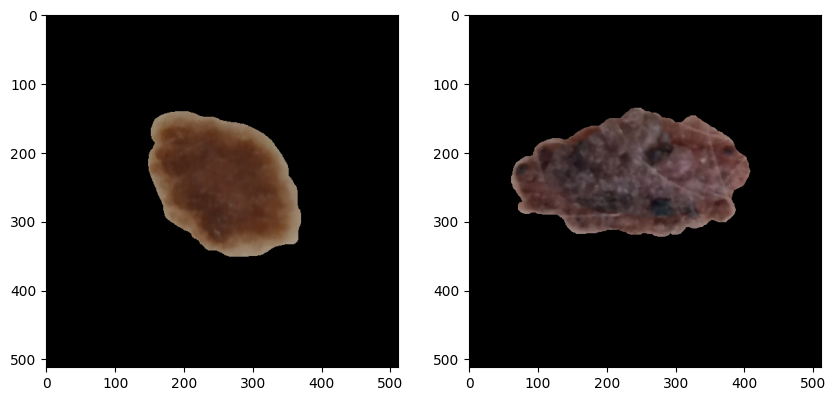

In [161]:
import cv2
import numpy as np
from sklearn.cluster import KMeans

def load_masked_image(image_path, mask_path):
    # read image in BGR
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    # convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    masked_image = cv2.bitwise_and(image, image, mask=mask) # apply mask to image
    return masked_image

image_path = '..\\data\\shanon_training\\PAT_627_1188_503.PNG'
mask_path = '..\\data\\shanon_masks_groundtruth\\PAT_627_1188_503.PNG'
masked_image = load_masked_image(image_path, mask_path)

image_path1 = '..\\data\\shanon_training\\PAT_1520_1777_935.PNG'
mask_path1 = '..\\data\\shanon_masks_groundtruth\\PAT_1520_1777_935.PNG'
masked_image1 = load_masked_image(image_path1, mask_path1)

# display
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(masked_image)
plt.subplot(1, 2, 2)
plt.imshow(masked_image1)
plt.show()

To measure the color irregularity of a skin lesion in a masked image, we can use a clustering algorithm like K-means to group similar colors in the lesion. Then, we can calculate the color irregularity as the ratio of the number of clusters (i.e., distinct color groups) to the total area of the lesion. A higher ratio indicates higher color irregularity.

The color_clustering function takes the masked image and the desired number of clusters (default is 7). It reshapes the image into a 2D array of pixel values and removes the black background pixels. Then, it applies the K-means clustering algorithm to group the remaining pixels into color clusters.

The color_irregularity function calls the color_clustering function to get the cluster labels for each pixel. It calculates the number of unique clusters found (i.e., distinct color groups) and divides it by the lesion area (non-black pixels) to get the color irregularity.

predefine a list of target colors and assign each pixel to its closest color in that list. This way, we always have a maximum of 6 clusters.

color_clustering function now takes the target_colors parameter instead of num_clusters, and it assigns each pixel to its closest color in the target colors list. The color_irregularity function now takes the target_colors parameter instead of num_clusters, and it calculates the number of unique colors found (i.e., distinct color groups) and divides it by the lesion area (non-black pixels) to get the color irregularity.

In [184]:
def closest_color(pixel, target_colors):
    distances = cdist([pixel], target_colors, metric='euclidean')
    return target_colors[np.argmin(distances)]

# def color_clustering(masked_image, target_colors):
#     data = masked_image.reshape((-1, 3))  # Reshape to 2D array
#     data = data[data.sum(axis=-1) != 0]  # Remove black background pixels

#     clustered_data = np.array([closest_color(pixel, target_colors) for pixel in data])
#     labels = np.array([np.argmin(cdist([pixel], target_colors, metric='euclidean')) for pixel in data])

#     return labels, clustered_data

def color_irregularity(masked_image, target_colors):
    labels, _ = color_clustering(masked_image, target_colors)
    num_unique_colors_found = len(np.unique(labels))
    return num_unique_colors_found

target_colors = np.array([
    (197, 188, 217), # white
    (41, 31, 30),   # black
    (118, 21, 17),  # red
    (153, 76, 0),  # light brown
    (102, 51, 0),  # dark brown
    (70, 130, 180)  # blue-gray
])

In [185]:
colorasymmetry_img_np = np.array(colorasymmetry_img)
irregular = color_irregularity(colorasymmetry_img_np, target_colors)
homogeneous_brown_img_np = np.array(homogeneous_brown_img)
smooth = color_irregularity(homogeneous_brown_img_np, target_colors)
print('Irregularly colored image:', irregular)
print('Smoothly colored image:', smooth)

Irregularly colored image: 6
Smoothly colored image: 2


Smoothly colored image: 2 because in addition to brown, there is white background

Now, to skin lesion images

In [186]:
masked_image_np = np.array(masked_image)
benign = color_irregularity(masked_image_np, target_colors)
masked_image1_np = np.array(masked_image1)
malignant = color_irregularity(masked_image1_np, target_colors)
print('Benign image:', benign)
print('Malignant image:', malignant)

Benign image: 5
Malignant image: 6
